In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import feature_selection

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors

#import seaborn as sns
from sqlalchemy import create_engine

In [2]:
from sklearn.externals import joblib
model_path = os.path.join('./models_trained')
if not os.path.isdir(model_path):
    os.makedirs(model_path)

In [3]:
import pandas as pd
%matplotlib inline

In [4]:
#sns.set_context(font_scale=1.2)

In [5]:
font = {'family'        : 'sans-serif',
        'sans-serif'    : ['Computer Modern Sans serif'],
        'weight'        : 'regular',
        'size'          : 12}

text = {'usetex'        : False}

plt.rc('font', **font)
plt.rc('text', **text)

In [6]:
engine = create_engine('sqlite:///../O2RBpipeline/Low_threshO2rbogus-dev.db')

## Load the tables from the DB

Using a merge we can get the detected portion of the objects, with the
recovered data, and the correct simulated data.

In [7]:
dt_zps = pd.merge(pd.read_sql_table('Detected', engine),
                  pd.read_sql_query("""SELECT 
                                        Detected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM Detected
                                        LEFT JOIN Reals
                                            ON Detected.id==Reals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==Reals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_sps = pd.merge(pd.read_sql_table('SDetected', engine),
                  pd.read_sql_query("""SELECT 
                                        SDetected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM SDetected
                                        LEFT JOIN SReals
                                            ON SDetected.id==SReals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==SReals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_ois = pd.merge(pd.read_sql_table('DetectedOIS', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedOIS.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedOIS
                                        LEFT JOIN RealsOIS
                                            ON DetectedOIS.id==RealsOIS.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsOIS.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_hot = pd.merge(pd.read_sql_table('DetectedHOT', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedHOT.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedHOT
                                        LEFT JOIN RealsHOT
                                            ON DetectedHOT.id==RealsHOT.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsHOT.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [8]:
dt_ois['MAG'] = dt_ois['MAG_APER'] - 1.13079840595
dt_zps['MAG'] = dt_zps['MAG_APER'] - 3.60046548531
dt_hot['MAG'] = dt_hot['MAG_APER'] + 6.64070381825
dt_sps['MAG'] = -2.5*np.log10(dt_sps['cflux']) + 16.6023808276

In [9]:
dt_ois['MU'] = dt_ois.MAG/(dt_ois.A_IMAGE*dt_ois.B_IMAGE)
dt_zps['MU'] = dt_zps.MAG/(dt_zps.A_IMAGE*dt_zps.B_IMAGE)
dt_hot['MU'] = dt_hot.MAG/(dt_hot.A_IMAGE*dt_hot.B_IMAGE)
dt_sps['MU'] = dt_sps.MAG/(dt_sps.a*dt_sps.b)

In [10]:
dt_ois['SN'] = dt_ois.FLUX_APER/dt_ois.FLUXERR_APER
dt_zps['SN'] = dt_zps.FLUX_APER/dt_zps.FLUXERR_APER
dt_hot['SN'] = dt_hot.FLUX_APER/dt_hot.FLUXERR_APER
dt_sps['SN'] = dt_sps.cflux/np.sqrt(dt_sps.cflux)

* Mean magniutde difference for Zackay is 1.05939544157
* Mean magniutde difference for Bramich is 5.90741295815
* Mean magniutde difference for Hotpans is 5.82769360385

From notebook threesome

In [11]:
dt_ois.IS_REAL = dt_ois.IS_REAL.astype(int)
dt_zps.IS_REAL = dt_zps.IS_REAL.astype(int)
dt_hot.IS_REAL = dt_hot.IS_REAL.astype(int)
dt_sps.IS_REAL = dt_sps.IS_REAL.astype(int)

In [12]:
dt_ois.describe()

,id,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,RATIO,ROUNDNESS,PEAK_CENTROID,IS_REAL,image_id,sim_mag,sim_id,MAG,MU,SN
count,7243.000000,7243.000000,7.243000e+03,7243.000000,7243.000000,7243.000000,7.243000e+03,7243.000000,7243.000000,7243.000000,...,7243.000000,7243.000000,7243.000000,7243.000000,7243.000000,1037.000000,1037.000000,7243.000000,7243.000000,7243.000000
mean,3622.000000,80.198537,3.252571e+04,333.016560,16.362147,0.034296,1.045809e+04,228.245299,19.502805,3.245288,...,0.750445,1.632069,0.833770,0.143173,41.051636,14.050822,640.366442,18.372006,18.448812,73.674667
std,2091.018332,74.461966,1.900277e+05,1825.243954,2.070201,0.027251,5.639415e+04,1592.201378,14.585907,17.478089,...,0.222959,0.677065,0.998081,0.350273,26.048912,1.757376,439.352495,14.585907,36.917711,187.436311
min,1.000000,1.000000,6.143619e+01,6.487103,8.074000,0.000300,-3.044754e+04,10.839480,9.417900,0.000200,...,0.000000,1.000000,0.002970,0.000000,1.000000,8.522473,1.000000,8.287102,0.056306,-467.180931
25%,1811.500000,24.000000,6.949910e+02,25.771650,15.118900,0.012500,5.701752e+02,23.370560,16.128000,0.017300,...,0.605662,1.188371,0.359132,0.000000,20.000000,12.889248,261.000000,14.997202,3.988485,17.474663
50%,3622.000000,57.000000,2.117349e+03,43.324580,16.685500,0.027100,1.289122e+03,35.211630,17.224300,0.036200,...,0.800000,1.385281,0.538080,0.000000,34.000000,14.334183,597.000000,16.093502,8.629303,30.003193
75%,5432.500000,121.000000,8.962685e+03,93.725730,17.895050,0.050400,3.538398e+03,60.299880,18.109950,0.062150,...,0.944444,1.857392,0.956898,0.000000,63.000000,15.349046,932.000000,16.979152,18.097013,62.917648
max,7243.000000,444.000000,5.894087e+06,82914.270000,20.528900,0.130100,1.709430e+06,89210.790000,99.000000,99.000000,...,1.000000,9.717622,18.116716,1.000000,100.000000,17.477257,1500.000000,97.869202,333.426005,5645.582872


In [13]:
dt_hot.describe()

,id,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,RATIO,ROUNDNESS,PEAK_CENTROID,IS_REAL,image_id,sim_mag,sim_id,MAG,MU,SN
count,67066.000000,67066.000000,6.706600e+04,6.706600e+04,67066.000000,67066.000000,6.706600e+04,6.706600e+04,67066.000000,67066.000000,...,67066.000000,67066.000000,67066.000000,67066.000000,67066.000000,1496.000000,1496.000000,67066.000000,67066.000000,67065.000000
mean,33533.500000,1269.491575,9.173076e+06,2.035241e+05,15.806931,0.047121,3.875945e+06,2.614813e+05,16.848408,0.835859,...,0.597541,2.362647,1.349103,0.022306,45.698461,13.767564,933.094251,23.489112,38.102468,23.656003
std,19360.430914,1322.273476,1.546777e+08,9.520633e+05,4.102982,0.020775,4.585374e+07,1.161841e+06,8.118236,8.486990,...,0.250653,1.775778,9.171316,0.147679,26.063280,1.579027,524.428266,8.118236,30.502466,74.438779
min,1.000000,1.000000,7.699356e+01,8.447430e+00,-0.942300,0.000200,-7.113857e+07,0.000000e+00,0.406600,0.000200,...,0.000000,1.000000,0.000300,0.000000,1.000000,8.522473,1.000000,7.047304,0.000567,-268.613025
25%,16767.250000,203.000000,4.084130e+02,1.827710e+01,15.070400,0.033400,3.049715e+02,2.513629e+01,15.850175,0.058500,...,0.400000,1.609225,0.421319,0.000000,30.000000,12.724367,520.750000,22.490879,17.939325,10.008846
50%,33533.500000,772.000000,9.916735e+02,3.743698e+01,17.509050,0.045400,7.276100e+02,4.288128e+01,17.845250,0.079300,...,0.538462,2.002134,0.631802,0.000000,34.000000,13.723264,964.000000,24.485954,33.432788,13.689802
75%,50299.750000,1932.000000,9.372305e+03,2.024887e+02,18.472275,0.060000,4.570220e+03,1.779981e+02,18.789375,0.108500,...,0.769231,2.787966,1.123410,0.000000,61.000000,15.023735,1348.250000,25.430079,53.633989,18.557035
max,67066.000000,5453.000000,2.381925e+10,6.397728e+07,20.283900,0.127600,6.876514e+09,2.564287e+07,99.000000,196.077600,...,1.000000,167.780120,1120.271845,1.000000,120.000000,17.477257,1800.000000,105.640704,408.088724,4371.529210


In [14]:
dt_zps.describe()

,id,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,RATIO,ROUNDNESS,PEAK_CENTROID,IS_REAL,image_id,sim_mag,sim_id,MAG,MU,SN
count,30977.000000,30977.000000,30977.000000,30977.000000,30977.000000,30977.000000,30977.000000,30977.000000,30977.000000,30977.000000,...,30977.000000,30977.000000,30977.000000,30977.000000,30977.000000,1697.000000,1697.000000,30977.000000,30977.000000,30977.000000
mean,15489.000000,212.872777,936.366663,5.680377,19.252124,0.035463,239.487967,4.451418,21.261034,1.884897,...,0.616583,2.348790,1.157844,0.054783,61.272880,13.892081,893.725398,17.660569,20.177165,53.689202
std,8942.433981,191.293419,4486.098914,4.638872,1.531099,0.024123,1023.868531,0.637807,10.691854,13.302418,...,0.257041,1.770651,1.916425,0.227559,33.646713,1.587112,517.751770,10.691854,31.775768,229.212377
min,1.000000,1.000000,17.458650,1.998249,11.832000,0.000100,-1658.539000,3.136679,13.308600,0.000100,...,0.000000,1.000000,0.000000,0.000000,1.000000,8.522473,1.000000,9.708135,0.050072,-371.266298
25%,7745.000000,69.000000,73.971780,3.180624,18.498800,0.016100,66.250240,4.292989,19.388100,0.027500,...,0.428571,1.481600,0.428117,0.000000,36.000000,12.848043,446.000000,15.787635,6.213114,15.024279
50%,15489.000000,151.000000,148.404000,4.233183,19.571400,0.032300,94.425640,4.442578,20.062300,0.050700,...,0.625000,1.882565,0.678158,0.000000,70.000000,13.872743,893.000000,16.461835,13.649085,21.425817
75%,23233.000000,311.000000,398.545500,6.012926,20.327300,0.049600,175.687900,4.469555,20.447000,0.072300,...,0.800000,2.623457,1.218317,0.000000,83.000000,15.109944,1330.000000,16.846535,24.124177,39.498796
max,30977.000000,1049.000000,185008.900000,64.380500,21.895000,0.137600,47484.380000,14.016410,99.000000,99.000000,...,1.000000,34.804979,55.333896,1.000000,120.000000,17.477257,1800.000000,95.399535,494.577427,10700.705352


In [15]:
dt_sps.describe()

,id,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,...,RATIO,ROUNDNESS,PEAK_CENTROID,IS_REAL,image_id,sim_mag,sim_id,MAG,MU,SN
count,118777.000000,118777.000000,118777.000000,118777.000000,118777.000000,118777.000000,118777.000000,118777.000000,118777.000000,118777.000000,...,118777.000000,118777.000000,118777.000000,118777.000000,118777.000000,1431.000000,1431.000000,118777.000000,118777.000000,118777.000000
mean,59389.000000,0.003629,72.570801,72.570801,1270.748495,1278.369903,787.355170,795.844692,1274.579512,791.602720,...,0.614790,3.332040,1.731066,0.012048,37.766554,13.868255,924.423480,19.022691,17.927815,0.475425
std,34288.110799,0.003462,358.903854,358.903854,812.063511,812.269911,479.065909,479.781808,812.178065,479.412621,...,0.263361,2.329422,2.553050,0.109100,28.493288,1.623432,510.025887,1.488560,18.336987,0.946951
min,1.000000,0.000278,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000509,0.000038,0.000000,1.000000,8.522473,2.000000,8.592772,0.004308,0.038399
25%,29695.000000,0.001627,8.000000,8.000000,559.000000,567.000000,373.000000,380.000000,562.562356,376.834950,...,0.428571,1.714990,0.625931,0.000000,11.000000,12.802867,472.500000,18.367978,4.763361,0.209764
50%,59389.000000,0.003057,15.000000,15.000000,1210.000000,1218.000000,748.000000,756.000000,1214.480067,751.918853,...,0.666667,2.571684,1.153827,0.000000,33.000000,13.860178,920.000000,19.237517,11.699602,0.297148
75%,89083.000000,0.003475,33.000000,33.000000,1951.000000,1959.000000,1202.000000,1213.000000,1955.211105,1207.090444,...,0.800000,4.253604,2.025283,0.000000,63.000000,15.117971,1356.500000,19.993721,25.333157,0.443487
max,118777.000000,0.051389,17200.000000,17200.000000,2725.000000,2725.000000,1649.000000,1649.000000,2725.000000,1649.000000,...,1.000000,43.544891,138.086416,1.000000,120.000000,17.477257,1800.000000,23.680763,231.772795,39.987274


/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


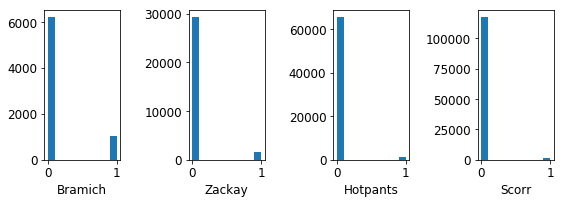

In [16]:
plt.figure(figsize=(8,3))
plt.subplot(141)
plt.hist(dt_ois['IS_REAL'])
plt.xlabel('Bramich')
plt.subplot(142)
plt.hist(dt_zps['IS_REAL'])
plt.xlabel('Zackay')
plt.subplot(143)
plt.hist(dt_hot['IS_REAL'])
plt.xlabel('Hotpants')
plt.subplot(144)
plt.hist(dt_sps['IS_REAL'])
plt.xlabel('Scorr')
plt.tight_layout()

## Select the columns 

We select for both methods the columns related to every detection recovered data. 

There are 35 columns relevant, and this would be the biggest features set for training and testing.
Also we perform a random sampling, to be ablo tohandle the data

In [17]:
d_ois = dt_ois[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', 'MAG', 'MU', 'SN']]

In [18]:
d_zps = dt_zps[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', 'MAG', 'MU', 'SN']]

In [19]:
d_hot = dt_hot[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', 'MAG', 'MU', 'SN']]

In [20]:
dt_sps.columns

Index([           u'id',        u'thresh',          u'npix',         u'tnpix',
                u'xmin',          u'xmax',          u'ymin',          u'ymax',
                   u'x',             u'y',            u'x2',            u'y2',
                  u'xy',         u'errx2',         u'erry2',         u'errxy',
                   u'a',             u'b',         u'theta',           u'cxx',
                 u'cyy',           u'cxy',         u'cflux',          u'flux',
               u'cpeak',          u'peak',        u'xcpeak',        u'ycpeak',
               u'xpeak',         u'ypeak',          u'flag',        u'DELTAX',
              u'DELTAY',         u'RATIO',     u'ROUNDNESS', u'PEAK_CENTROID',
             u'IS_REAL',      u'image_id',       u'sim_mag',        u'sim_id',
                 u'MAG',            u'MU',            u'SN'],
      dtype='object')

In [21]:
d_sps = dt_sps[[u'thresh', u'npix', u'tnpix', u'xmin', u'xmax', u'ymin', u'ymax', u'x', u'y', u'x2', u'y2',
                  u'xy', u'errx2', u'erry2', u'errxy', u'a', u'b', u'theta', u'cxx', u'cyy', u'cxy', u'cflux',          u'flux',
               u'cpeak', u'peak', u'xcpeak', u'ycpeak', u'xpeak', u'ypeak', u'flag', u'DELTAX',
              u'DELTAY', u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', u'MAG', u'MU', u'SN']]

In [22]:
len(d_zps.columns)

38

In [23]:
print d_zps.columns

Index([     u'FLUX_ISO',   u'FLUXERR_ISO',       u'MAG_ISO',    u'MAGERR_ISO',
           u'FLUX_APER',  u'FLUXERR_APER',      u'MAG_APER',   u'MAGERR_APER',
           u'FLUX_AUTO',  u'FLUXERR_AUTO',      u'MAG_AUTO',   u'MAGERR_AUTO',
          u'BACKGROUND',     u'THRESHOLD',      u'FLUX_MAX',      u'X2_IMAGE',
            u'Y2_IMAGE',      u'XY_IMAGE',     u'CXX_IMAGE',     u'CYY_IMAGE',
           u'CXY_IMAGE',       u'A_IMAGE',       u'B_IMAGE',   u'THETA_IMAGE',
              u'MU_MAX',         u'FLAGS',    u'FWHM_IMAGE',    u'ELONGATION',
         u'ELLIPTICITY',    u'CLASS_STAR',        u'DELTAX',        u'DELTAY',
               u'RATIO',     u'ROUNDNESS', u'PEAK_CENTROID',           u'MAG',
                  u'MU',            u'SN'],
      dtype='object')


### Preprocesing
If we convert this to matrix (numpy arrays) we can then *preprocess* this data to become Machine treatable.

In [24]:
np.sum(np.sum(d_hot==np.nan))

0

In [25]:
d_ois = d_ois.replace([np.inf, -np.inf], np.nan)
d_hot = d_hot.replace([np.inf, -np.inf], np.nan)
d_zps = d_zps.replace([np.inf, -np.inf], np.nan)
d_sps = d_sps.replace([np.inf, -np.inf], np.nan)

In [26]:
d_ois.dropna(inplace=True)
d_hot.dropna(inplace=True)
d_zps.dropna(inplace=True)
d_sps.dropna(inplace=True)

### Scaled

This scaling process transforms data to match distributions with zero mean and unit variance.

In [27]:
X_zps = d_zps.as_matrix()
X_ois = d_ois.as_matrix()
X_hot = d_hot.as_matrix()
X_sps = d_sps.as_matrix()

In [28]:
scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)
scaler_sps = preprocessing.StandardScaler().fit(X_sps)

In [29]:
X_ois_scaled = scaler_ois.transform(X_ois)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)
X_sps_scaled = scaler_sps.transform(X_sps)

In [30]:
joblib.dump(scaler_ois, os.path.join(model_path, 'scaler_ois.pkl'))
joblib.dump(scaler_zps, os.path.join(model_path, 'scaler_zps.pkl'))
joblib.dump(scaler_hot, os.path.join(model_path, 'scaler_hot.pkl'))
joblib.dump(scaler_sps, os.path.join(model_path, 'scaler_sps.pkl'))

['./models_trained/scaler_sps.pkl']

# Feature selection

Choosing a ranker
-----------------

It is important to know that feature selection is a general term for tossing the descriptors that doesn't work
as expected. This is not always mentioned, but in general one firstly should decide which ML algorithm will use,
for example a support vector machines. So, select a feature should be introduced tied to the algorithm applied for selection and perfomance testing. 

If it is not like this, one could provide misleading information, like jumping to the conclusion that there is no relation at all between a poor performer feature and the objective class, since the method for ML may be somehow not able to grab the information the feature provides. 

A quick notion of this is the non-linearities present in the profound behaviour of the reality, that we want to learn using linear kernels in a Support VM algorithm.

In [31]:
Y_sps = dt_sps['IS_REAL']
Y_ois = dt_ois['IS_REAL']
Y_zps = dt_zps['IS_REAL']
Y_hot = dt_hot['IS_REAL']

In [32]:
Y_ois = dt_ois.iloc[d_ois.index]['IS_REAL']
Y_sps = dt_sps.iloc[d_sps.index]['IS_REAL']
Y_zps = dt_zps.iloc[d_zps.index]['IS_REAL']
Y_hot = dt_hot.iloc[d_hot.index]['IS_REAL']

In [33]:
print len(X_ois_scaled), len(Y_ois)
print len(X_zps_scaled), len(Y_zps)
print len(X_hot_scaled), len(Y_hot)
print len(X_sps_scaled), len(Y_sps)

7243 7243
30977 30977
67065 67065
118777 118777


In [34]:
fraction_reals_ois = sum(Y_ois)/float(len(Y_ois))
fraction_bogus_ois = 1. - fraction_reals_ois

In [35]:
print 'The fraction of reals is: {}'.format(fraction_reals_ois)
print 'The fraction of bogus is: {}'.format(fraction_bogus_ois)
print '\n'
print 'The ratio is: {}'.format(fraction_reals_ois/fraction_bogus_ois)

The fraction of reals is: 0.143172718487
The fraction of bogus is: 0.856827281513


The ratio is: 0.167096358363


In [36]:
fraction_reals_zps = sum(Y_zps)/float(len(Y_zps))
fraction_bogus_zps = 1. - fraction_reals_zps

In [37]:
print 'The fraction of reals is: {}'.format(fraction_reals_zps)
print 'The fraction of bogus is: {}'.format(fraction_bogus_zps)
print '\n'
print 'The ratio is: {}'.format(fraction_reals_zps/fraction_bogus_zps)

The fraction of reals is: 0.0547825806243
The fraction of bogus is: 0.945217419376


The ratio is: 0.0579576502732


In [38]:
fraction_reals_hot = sum(Y_hot)/float(len(Y_hot))
fraction_bogus_hot = 1. - fraction_reals_hot

In [39]:
print 'The fraction of reals is: {}'.format(fraction_reals_hot)
print 'The fraction of bogus is: {}'.format(fraction_bogus_hot)
print '\n'
print 'The ratio is: {}'.format(fraction_reals_hot/fraction_bogus_hot)

The fraction of reals is: 0.0223067173638
The fraction of bogus is: 0.977693282636


The ratio is: 0.0228156598393


In [40]:
fraction_reals_sps = sum(Y_sps)/float(len(Y_sps))
fraction_bogus_sps = 1. - fraction_reals_sps

In [41]:
print 'The fraction of reals is: {}'.format(fraction_reals_sps)
print 'The fraction of bogus is: {}'.format(fraction_bogus_sps)
print '\n'
print 'The ratio is: {}'.format(fraction_reals_sps/fraction_bogus_sps)

The fraction of reals is: 0.0120477870295
The fraction of bogus is: 0.987952212971


The ratio is: 0.0121947062533


### Univariate selection (*f-test* + *SelectPercentile*)

In [42]:
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, chi2

In [43]:
percentile = 50.

/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or 

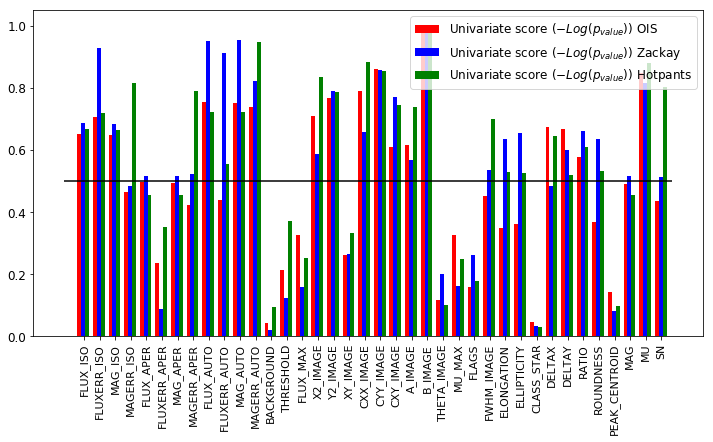

In [44]:
plt.figure(figsize=(12, 6))
#plt.subplot(131)
selector = SelectPercentile(mutual_info_classif, percentile=percentile)
selector.fit(X_ois_scaled, Y_ois)
scores = selector.scores_ #-np.log10(selector.pvalues_)
scores /= scores.max()

ois_selected_cols = selector.transform(np.arange(X_ois_scaled.shape[-1]))

plt.bar(np.arange(X_ois_scaled.shape[-1]), scores, width=.25,
        label=r'Univariate score ($-Log(p_{value})$) OIS', color='red')
plt.xticks(np.arange(X_ois_scaled.shape[-1])+0.3, d_ois.columns, rotation='vertical', fontsize=11)
#plt.title('OIS')

#plt.subplot(132)
selector = SelectPercentile(mutual_info_classif, percentile=percentile)
selector.fit(X_zps_scaled, Y_zps)
scores = selector.scores_ #-np.log10(selector.pvalues_)
scores /= scores.max()

zps_selected_cols = selector.transform(np.arange(X_zps_scaled.shape[-1]))

plt.bar(np.arange(X_zps_scaled.shape[-1])+0.25, scores, width=.25,
        label=r'Univariate score ($-Log(p_{value})$) Zackay', color='blue')
#plt.xticks(np.arange(X_zps_scaled.shape[-1]), dt_zps.columns, rotation='vertical', fontsize=9)
#plt.title('Zackay')

#plt.subplot(133)
selector = SelectPercentile(mutual_info_classif, percentile=percentile)
selector.fit(X_hot_scaled, Y_hot)
scores = selector.scores_ #-np.log10(selector.pvalues_)
scores /= scores.max()

hot_selected_cols = selector.transform(np.arange(X_hot_scaled.shape[-1]))

plt.bar(np.arange(X_hot_scaled.shape[-1])+0.5, scores, width=.25,
        label=r'Univariate score ($-Log(p_{value})$) Hotpants', color='green')
#plt.xticks(np.arange(X_hot_scaled.shape[-1]), dt_hot.columns, rotation='vertical', fontsize=9)
#plt.title('Hotpants')
plt.legend(loc='best')
plt.hlines(y=percentile/100., xmin=-1, xmax=38)

plt.show()

/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


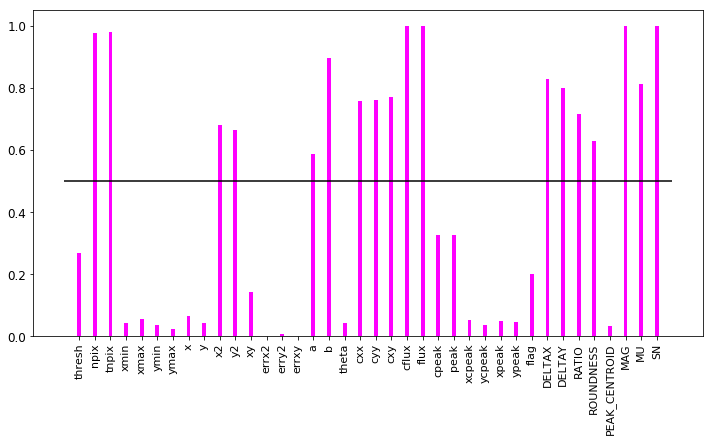

In [45]:
#plt.subplot(132)
plt.figure(figsize=(12, 6))
selector = SelectPercentile(mutual_info_classif, percentile=percentile)
selector.fit(X_sps_scaled, Y_sps)
scores = selector.scores_ #-np.log10(selector.pvalues_)
scores /= scores.max()

sps_selected_cols = selector.transform(np.arange(X_sps_scaled.shape[-1]))

plt.bar(np.arange(X_sps_scaled.shape[-1]), scores, width=.25,
        label=r'Univariate score ($-Log(p_{value})$) Scorr', color='magenta')
plt.xticks(np.arange(X_sps_scaled.shape[-1]), d_sps.columns, rotation='vertical', fontsize=11)
#plt.title('OIS')
plt.hlines(y=percentile/100., xmin=-1, xmax=38)

plt.show()

### Scaled

This scaling process transforms data to match distributions with zero mean and unit variance.

In [46]:
d_zps = d_zps[d_zps.columns[zps_selected_cols][0]]
d_ois = d_ois[d_ois.columns[ois_selected_cols][0]]
d_hot = d_hot[d_hot.columns[hot_selected_cols][0]]
d_sps = d_sps[d_sps.columns[sps_selected_cols][0]]

In [47]:
joblib.dump(zps_selected_cols, os.path.join(model_path, 'zps_selected_cols.pkl'))
joblib.dump(ois_selected_cols, os.path.join(model_path, 'ois_selected_cols.pkl'))
joblib.dump(hot_selected_cols, os.path.join(model_path, 'hot_selected_cols.pkl'))
joblib.dump(sps_selected_cols, os.path.join(model_path, 'sps_selected_cols.pkl'))

['./models_trained/sps_selected_cols.pkl']

In [48]:
X_zps = d_zps.as_matrix()
X_ois = d_ois.as_matrix()
X_hot = d_hot.as_matrix()
X_sps = d_sps.as_matrix()

In [49]:
scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_sps = preprocessing.StandardScaler().fit(X_sps)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)

In [50]:
X_sps_scaled = scaler_sps.transform(X_sps)
X_ois_scaled = scaler_ois.transform(X_ois)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)

In [51]:
joblib.dump(scaler_zps, os.path.join(model_path, 'zps_second_scaler.pkl'))
joblib.dump(scaler_ois, os.path.join(model_path, 'ois_second_scaler.pkl'))
joblib.dump(scaler_hot, os.path.join(model_path, 'hot_second_scaler.pkl'))
joblib.dump(scaler_sps, os.path.join(model_path, 'sps_second_scaler.pkl'))

['./models_trained/sps_second_scaler.pkl']

**Recursive feature elimination**

This a feature selection technique, that is completely supervised (in opposition to a Principal Component Analisys), and aims to elminate features that have poor description power in the chosen model environment.

For example in the code block below, we use a *c45* decision tree, and a *step* value of 3. This means, that we will train a *c45* algorithm tossing three random features, repeteadly, until we get a notion of which set of features get better scores (*f1* in this case). We repeat this using a 10 fold cross validation, and then decide which features we eliminate.

So it is a recursive technique that depends strongly on the *c45* election. It is clear that features that perform poor on a decision tree can be good descriptors for SVM for example. 

### OIS

In [52]:
svc = SVC(kernel='linear', 
          cache_size=600, 
          class_weight='balanced', 
          probability=False)

In [53]:
rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=StratifiedKFold(6),
              scoring='f1', n_jobs=3)
%time rfecv.fit(np.ascontiguousarray(X_ois_scaled), Y_ois)

CPU times: user 3.74 s, sys: 1.58 s, total: 5.32 s
Wall time: 19.6 s


RFECV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
   estimator=SVC(C=1.0, cache_size=600, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=3, scoring='f1', step=1, verbose=0)

In [54]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 15


In [55]:
import gc
gc.collect()

98

In [56]:
d_ois.columns[rfecv.support_]

Index([   u'FLUX_ISO',     u'MAG_ISO',   u'FLUX_APER',    u'MAG_APER',
         u'FLUX_AUTO',    u'MAG_AUTO', u'MAGERR_AUTO',    u'X2_IMAGE',
          u'Y2_IMAGE',   u'CXX_IMAGE',   u'CYY_IMAGE',     u'A_IMAGE',
           u'B_IMAGE',      u'DELTAX',          u'MU'],
      dtype='object')

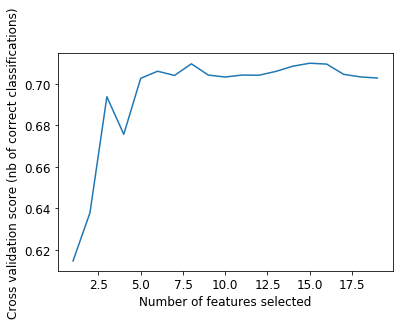

In [57]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [58]:
dB = d_ois[d_ois.columns[rfecv.support_]]

In [59]:
joblib.dump(rfecv, os.path.join(model_path, 'rfecv_ois.pkl'))

['./models_trained/rfecv_ois.pkl']

In [60]:
if rfecv.n_features_< 10:
    pd.scatter_matrix(dB, alpha=0.1, figsize=(8, 8), diagonal='kde')
    plt.show()

### Zackay

In [61]:
svc = SVC(kernel='linear', 
          cache_size=600, 
          class_weight='balanced', 
          probability=False)

In [62]:
c45 = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=33)

In [63]:
rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=StratifiedKFold(6),
              scoring='f1', n_jobs=3)

In [64]:
rfecv.fit(np.ascontiguousarray(X_zps_scaled), Y_zps)

RFECV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
   estimator=SVC(C=1.0, cache_size=600, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=3, scoring='f1', step=1, verbose=0)

In [65]:
gc.collect()

648

In [66]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 19


In [67]:
d_zps.columns[rfecv.support_]

Index([    u'FLUX_ISO',  u'FLUXERR_ISO',      u'MAG_ISO',    u'FLUX_AUTO',
       u'FLUXERR_AUTO',     u'MAG_AUTO',  u'MAGERR_AUTO',     u'X2_IMAGE',
           u'Y2_IMAGE',    u'CXX_IMAGE',    u'CYY_IMAGE',    u'CXY_IMAGE',
            u'B_IMAGE',   u'ELONGATION',  u'ELLIPTICITY',       u'DELTAY',
              u'RATIO',    u'ROUNDNESS',           u'MU'],
      dtype='object')

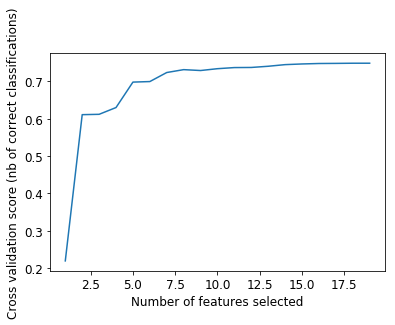

In [68]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [69]:
dZ = d_zps[d_zps.columns[rfecv.support_]]

In [70]:
joblib.dump(rfecv, os.path.join(model_path, 'rfecv_zps.pkl'))

['./models_trained/rfecv_zps.pkl']

In [71]:
if sum(rfecv.support_)< 10:
    pd.scatter_matrix(dZ, alpha=0.1, figsize=(10, 10), diagonal='kde')
    plt.grid()
    plt.show()

##  $S_{Corr}$

In [72]:
svc = SVC(kernel='linear', 
          cache_size=600, 
          class_weight='balanced', 
          probability=False)

In [73]:
rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=StratifiedKFold(6),
              scoring='f1', n_jobs=7)

In [74]:
rfecv.fit(np.ascontiguousarray(X_sps_scaled), Y_sps)

RFECV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
   estimator=SVC(C=1.0, cache_size=600, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=7, scoring='f1', step=1, verbose=0)

In [75]:
gc.collect()

234

In [76]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 10


In [77]:
d_sps.columns[rfecv.support_]

Index([  u'npix',  u'tnpix',     u'x2',      u'a',    u'cyy', u'DELTAY',
        u'RATIO',    u'MAG',     u'MU',     u'SN'],
      dtype='object')

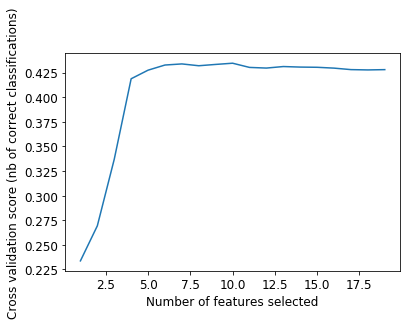

In [78]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [79]:
dS = d_sps[d_sps.columns[rfecv.support_]]

In [80]:
joblib.dump(rfecv, os.path.join(model_path, 'rfecv_sps.pkl'))

['./models_trained/rfecv_sps.pkl']

In [81]:
if sum(rfecv.support_)< 10:
    pd.scatter_matrix(dS, alpha=0.1, figsize=(10, 10), diagonal='kde')
    plt.grid()
    plt.show()

### HOTPANTS

In [82]:
svc = SVC(kernel='linear', 
          cache_size=600, 
          class_weight='balanced', 
          probability=False)

In [83]:
rfecv = feature_selection.RFECV(estimator=svc, step=3, cv=StratifiedKFold(6),
              scoring='f1', n_jobs=3)

In [84]:
rfecv.fit(np.ascontiguousarray(X_hot_scaled), Y_hot)

RFECV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
   estimator=SVC(C=1.0, cache_size=600, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=3, scoring='f1', step=3, verbose=0)

In [85]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 19


In [86]:
d_hot.columns[rfecv.support_]

Index([   u'FLUX_ISO', u'FLUXERR_ISO',     u'MAG_ISO',  u'MAGERR_ISO',
       u'MAGERR_APER',   u'FLUX_AUTO',    u'MAG_AUTO', u'MAGERR_AUTO',
          u'X2_IMAGE',    u'Y2_IMAGE',   u'CXX_IMAGE',   u'CYY_IMAGE',
         u'CXY_IMAGE',     u'A_IMAGE',     u'B_IMAGE',  u'FWHM_IMAGE',
            u'DELTAX',          u'MU',          u'SN'],
      dtype='object')

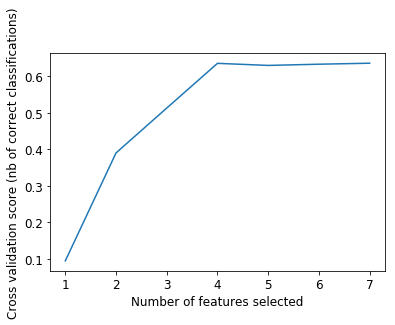

In [87]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [88]:
dH = d_hot[d_hot.columns[rfecv.support_]]

In [89]:
joblib.dump(rfecv, os.path.join(model_path, 'rfecv_hot.pkl'))

['./models_trained/rfecv_hot.pkl']

In [90]:
if rfecv.n_features_ < 7:
    pd.scatter_matrix(dH, alpha=0.1, figsize=(12, 12), diagonal='kde')
    plt.show()

In [91]:
gc.collect()

2469

## Post processing

Repeat the scaling pre processing so we get the selected features normalized

In [92]:
X_zps = dZ.as_matrix()
X_sps = dS.as_matrix()
X_ois = dB.as_matrix()
X_hot = dH.as_matrix()

scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_sps = preprocessing.StandardScaler().fit(X_sps)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)

X_ois_scaled = scaler_ois.transform(X_ois)
X_sps_scaled = scaler_sps.transform(X_sps)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)

In [93]:
joblib.dump(scaler_zps, os.path.join(model_path, 'zps_third_scaler.pkl'))
joblib.dump(scaler_ois, os.path.join(model_path, 'ois_third_scaler.pkl'))
joblib.dump(scaler_hot, os.path.join(model_path, 'hot_third_scaler.pkl'))
joblib.dump(scaler_sps, os.path.join(model_path, 'sps_third_scaler.pkl'))

['./models_trained/sps_third_scaler.pkl']

## Univariate feature selection

### ANOVA

In [94]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

transform = SelectPercentile(f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0, 
                                                      cache_size=500, 
                                                      class_weight='balanced') )])

In [95]:
def anova_svm(X, y, clf, title=None):
    score_means = list()
    score_stds = list()
    percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

    for percentile in percentiles:
        clf.set_params(anova__percentile=percentile)
        # Compute cross-validation score using 1 CPU
        this_scores = cross_val_score(clf, X, y, n_jobs=4)
        score_means.append(this_scores.mean())
        score_stds.append(this_scores.std())

    plt.errorbar(percentiles, score_means, np.array(score_stds))

    if title is None:
        plt.title(
            'Performance of the SVM-Anova varying the percentile of features selected')
    else:
        plt.title(title)
    plt.xlabel('Percentile')
    plt.ylabel('Prediction rate')

    plt.axis('tight')
    #plt.show()

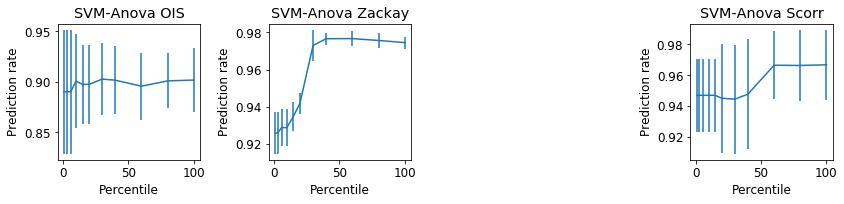

In [96]:
plt.figure(figsize=(12, 3))
plt.subplot(141)
anova_svm(np.ascontiguousarray(X_ois_scaled), Y_ois, clf, title='SVM-Anova OIS')
plt.subplot(142)
anova_svm(np.ascontiguousarray(X_zps_scaled), Y_zps, clf, title='SVM-Anova Zackay')
#plt.subplot(143)
#anova_svm(np.ascontiguousarray(X_hot_scaled), Y_hot, clf, title='SVM-Anova Hotpants')
plt.subplot(144)
anova_svm(np.ascontiguousarray(X_sps_scaled), Y_sps, clf, title='SVM-Anova Scorr')
plt.tight_layout()
plt.show()

In [97]:
gc.collect()

6331

### Feature importance by random forest


In [98]:
from sklearn.ensemble import ExtraTreesClassifier

In [99]:
def importance_forest(X, y, forest, cols=None, method=None):
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    if cols is not None:
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, cols[indices[f]-1], importances[indices[f]]))
    else:
        for f in range(X.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    #plt.figure(figsize=(6, 6))
    plt.title("Feature importances {}".format(method))
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    if cols is not None:
        plt.xticks(range(X.shape[1]), cols[indices-1], rotation='vertical', fontsize=10)
    else:
        plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    #plt.show()
    return [(cols[indices[f]-1], importances[indices[f]]) for f in range(X.shape[1])]

Feature ranking:
1. feature A_IMAGE (0.192587)
2. feature FLUX_ISO (0.081000)
3. feature FLUX_AUTO (0.076727)
4. feature CXX_IMAGE (0.074738)
5. feature CYY_IMAGE (0.069014)
6. feature Y2_IMAGE (0.064529)
7. feature X2_IMAGE (0.061748)
8. feature DELTAX (0.061271)
9. feature MAGERR_AUTO (0.058049)
10. feature B_IMAGE (0.057216)
11. feature MAG_AUTO (0.050364)
12. feature MAG_APER (0.046690)
13. feature FLUX_APER (0.037722)
14. feature MU (0.035480)
15. feature MAG_ISO (0.032867)
Feature ranking:
1. feature ELONGATION (0.117589)
2. feature CXY_IMAGE (0.105975)
3. feature FLUX_ISO (0.101354)
4. feature FLUXERR_ISO (0.087915)
5. feature FLUX_AUTO (0.081881)
6. feature FLUXERR_AUTO (0.056889)
7. feature DELTAY (0.052791)
8. feature B_IMAGE (0.047831)
9. feature CXX_IMAGE (0.041228)
10. feature RATIO (0.039128)
11. feature MAG_ISO (0.038944)
12. feature ELLIPTICITY (0.036656)
13. feature Y2_IMAGE (0.035731)
14. feature ROUNDNESS (0.030072)
15. feature X2_IMAGE (0.028389)
16. feature MU (0.0

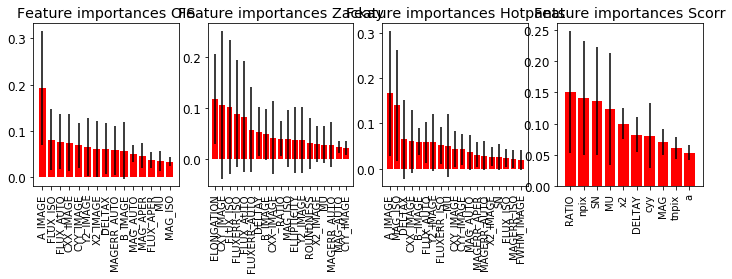

In [100]:
plt.figure(figsize=(12, 3))
plt.subplot(141)
ois_importance = importance_forest(X_ois_scaled, Y_ois, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                 cols=dB.columns, method='OIS')
plt.subplot(142)
zps_importance = importance_forest(X_zps_scaled, Y_zps, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                                   cols=dZ.columns, method='Zackay')
plt.subplot(143)
hot_importance = importance_forest(X_hot_scaled, Y_hot, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                                   cols=dH.columns, method='Hotpants')
plt.subplot(144)
sps_importance = importance_forest(X_sps_scaled, Y_sps, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                                   cols=dS.columns, method='Scorr')

In [101]:
acum=0
feats = []
for feat, imp in ois_importance:
    acum += imp
    feats.append(feat)
    if acum > .90: break

print acum, feats

0.931652559873 ['A_IMAGE', 'FLUX_ISO', 'FLUX_AUTO', 'CXX_IMAGE', 'CYY_IMAGE', 'Y2_IMAGE', 'X2_IMAGE', 'DELTAX', 'MAGERR_AUTO', 'B_IMAGE', 'MAG_AUTO', 'MAG_APER', 'FLUX_APER']


In [102]:
dB = dB[feats]

In [103]:
joblib.dump(feats, os.path.join(os.path.join(model_path, 'ois_feats_importance.pkl')))

['./models_trained/ois_feats_importance.pkl']

In [104]:
acum=0
feats = []
for feat, imp in zps_importance:
    acum += imp
    feats.append(feat)
    if acum > .90: break

print acum, feats

0.902374778155 ['ELONGATION', 'CXY_IMAGE', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'DELTAY', 'B_IMAGE', 'CXX_IMAGE', 'RATIO', 'MAG_ISO', 'ELLIPTICITY', 'Y2_IMAGE', 'ROUNDNESS', 'X2_IMAGE']


In [105]:
dZ = dZ[feats]

In [106]:
joblib.dump(feats, os.path.join(os.path.join(model_path, 'zps_feats_importance.pkl')))

['./models_trained/zps_feats_importance.pkl']

In [107]:
acum=0
feats = []
for feat, imp in hot_importance:
    acum += imp
    feats.append(feat)
    if acum > .90: break

print acum, feats

0.911366363775 ['A_IMAGE', 'MAG_ISO', 'DELTAX', 'CXX_IMAGE', 'B_IMAGE', 'FLUX_AUTO', 'Y2_IMAGE', 'FLUXERR_ISO', 'MU', 'CXY_IMAGE', 'CYY_IMAGE', 'MAG_AUTO', 'MAGERR_APER', 'MAGERR_AUTO', 'X2_IMAGE']


In [108]:
dH = dH[feats]

In [109]:
joblib.dump(feats, os.path.join(os.path.join(model_path, 'hot_feats_importance.pkl')))

['./models_trained/hot_feats_importance.pkl']

In [110]:
acum=0
feats = []
for feat, imp in sps_importance:
    acum += imp
    feats.append(feat)
    if acum > .90: break

print acum, feats

0.946603553195 ['RATIO', 'npix', 'SN', 'MU', 'x2', 'DELTAY', 'cyy', 'MAG', 'tnpix']


In [111]:
dS = dS[feats]

In [112]:
joblib.dump(feats, os.path.join(os.path.join(model_path, 'sps_feats_importance.pkl')))

['./models_trained/sps_feats_importance.pkl']

### Principal Component Analysis

In [113]:
X_zps = dZ.as_matrix()
X_sps = dS.as_matrix()
X_ois = dB.as_matrix()
X_hot = dH.as_matrix()

scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_sps = preprocessing.StandardScaler().fit(X_sps)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)

X_ois_scaled = scaler_ois.transform(X_ois)
X_sps_scaled = scaler_sps.transform(X_sps)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)

In [114]:
joblib.dump(scaler_zps, os.path.join(model_path, 'zps_fourth_scaler.pkl'))
joblib.dump(scaler_ois, os.path.join(model_path, 'ois_fourth_scaler.pkl'))
joblib.dump(scaler_hot, os.path.join(model_path, 'hot_fourth_scaler.pkl'))
joblib.dump(scaler_sps, os.path.join(model_path, 'sps_fourth_scaler.pkl'))

['./models_trained/sps_fourth_scaler.pkl']

**OIS**

In [115]:
pca = decomposition.PCA(svd_solver='randomized', n_components=min(X_ois_scaled.shape[-1], 6))

pca.fit(X_ois_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

In [116]:
X_ois_t = pca.transform(X_ois_scaled)

/home/bruno/.virtualenvs/daily/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


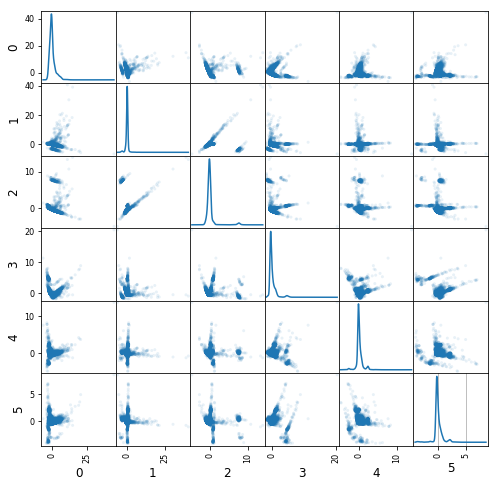

In [117]:
pd.scatter_matrix(pd.DataFrame(X_ois_t), alpha=0.1, figsize=(8, 8), diagonal='kde')
plt.grid()
plt.show()

**Zackay**

In [118]:
pca = decomposition.PCA(svd_solver='randomized', n_components=min(X_zps_scaled.shape[-1], 6))

pca.fit(X_zps_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

In [119]:
X_zps_t = pca.transform(X_zps_scaled)

/home/bruno/.virtualenvs/daily/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


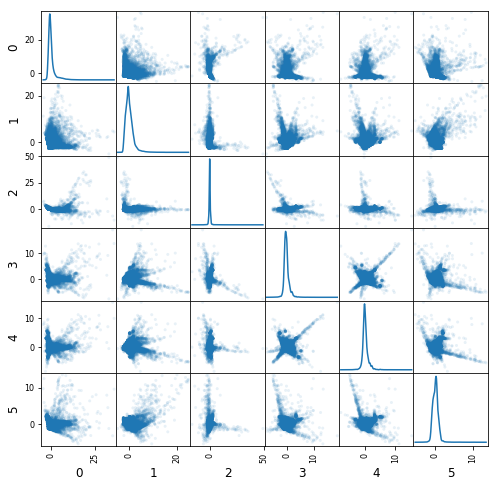

In [120]:
pd.scatter_matrix(pd.DataFrame(X_zps_t), alpha=0.1, figsize=(8, 8), diagonal='kde')
plt.show()

**HOTPANTS**

In [121]:
pca = decomposition.PCA(svd_solver='randomized', n_components=min(X_hot_scaled.shape[-1], 6))

pca.fit(X_hot_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

In [122]:
X_hot_t = pca.transform(X_hot_scaled)

/home/bruno/.virtualenvs/daily/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


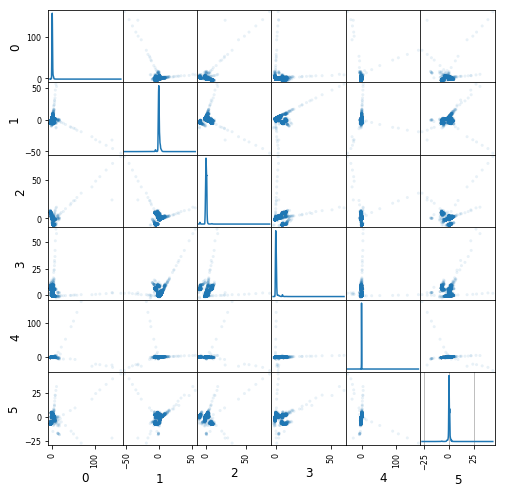

In [123]:
pd.scatter_matrix(pd.DataFrame(X_hot_t), alpha=0.1, figsize=(8, 8), diagonal='kde')
plt.grid()
plt.show()

**$S_{corr}$**

In [124]:
pca = decomposition.PCA(svd_solver='randomized', n_components=min(X_sps_scaled.shape[-1], 6))

pca.fit(X_sps_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

In [125]:
X_sps_t = pca.transform(X_sps_scaled)

/home/bruno/.virtualenvs/daily/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


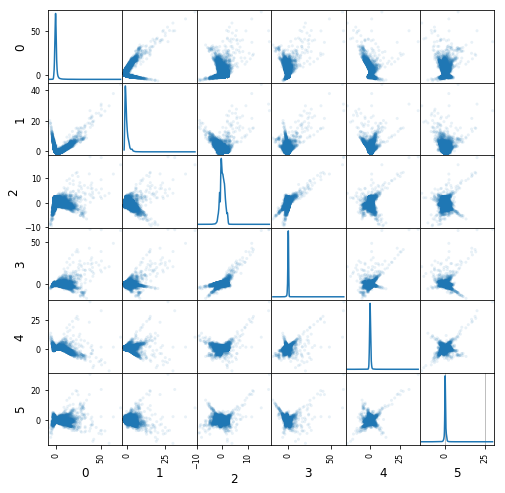

In [126]:
pd.scatter_matrix(pd.DataFrame(X_sps_t), alpha=0.1, figsize=(8, 8), diagonal='kde')
plt.grid()
plt.show()

# Machine Learning perfomance comparison

## Comparing methods algorithm to algorithm

In [127]:
def experiment(clf, x, y, nfolds=10, printing=False):
    skf = StratifiedKFold(n_splits=nfolds)
    probabilities = None # np.array([])
    predictions = np.array([])
    y_testing = np.array([])
    
    for train, test in skf.split(x, y):
        
        x_train = x[train]
        y_train = y[train]
        clf.fit(x_train, y_train)

        x_test = x[test]
        y_test = y[test]
        pr = clf.predict(x_test)
        probs = clf.predict_proba(x_test)  #[:, 0]
        
        probabilities = (
            probs if probabilities is None else
            np.vstack([probabilities, probs]))
        predictions = np.hstack([predictions, pr])
        y_testing = np.hstack([y_testing, y_test])

    if printing: 
        print metrics.classification_report(y_testing, predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y_testing, 1.-probabilities[:, 0])
    prec_rec_curve = metrics.precision_recall_curve(y_testing, 1.- probabilities[:, 0])
    roc_auc = metrics.auc(fpr, tpr)
    return {'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'prec_rec_curve': prec_rec_curve,
            'y_test': y_testing, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_testing, predictions),
            'model': clf
            }

### K-Nearest Neighbors


**OIS**

In [130]:
rslts_knn_ois_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_ois_scaled, Y_ois.as_matrix())

In [131]:
joblib.dump(rslts_knn_ois_uniform['model'], os.path.join(model_path, 'knn_ois.pkl'))

['./models_trained/knn_ois.pkl']

**Zackay**

In [132]:
rslts_knn_zps_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_zps_scaled, Y_zps.as_matrix())
joblib.dump(rslts_knn_zps_uniform['model'], os.path.join(model_path, 'knn_zps.pkl'))

['./models_trained/knn_zps.pkl']

**Hotpants**

In [133]:
rslts_knn_hot_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_hot_scaled, Y_hot.as_matrix())
joblib.dump(rslts_knn_zps_uniform['model'], os.path.join(model_path, 'knn_hot.pkl'))

['./models_trained/knn_hot.pkl']

**$S_{corr}$**

In [134]:
rslts_knn_sps_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_sps_scaled, Y_sps.as_matrix())
joblib.dump(rslts_knn_zps_uniform['model'], os.path.join(model_path, 'knn_sps.pkl'))

['./models_trained/knn_sps.pkl']

### Support vector machines

**OIS**

In [135]:
rslts_ois_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [136]:
rslts_zps_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [137]:
rslts_hot_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_hot_scaled, Y_hot.as_matrix())

**$S_{corr}$**

In [138]:
rslts_sps_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_sps_scaled, Y_sps.as_matrix())

### Decision tree (gini)

**OIS**

In [139]:
rslts_ois_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [140]:
rslts_zps_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [141]:
rslts_hot_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_hot_scaled, Y_hot.as_matrix())

**$S_{corr}$**

In [142]:
rslts_sps_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_sps_scaled, Y_sps.as_matrix())

### Random forest

**OIS**

In [143]:
rslts_ois_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [144]:
rslts_zps_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [145]:
rslts_hot_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_hot_scaled, Y_hot.as_matrix())

**$S_{corr}$**

In [146]:
rslts_sps_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_sps_scaled, Y_sps.as_matrix())

### DecisionTreeClassifier (C45)

**OIS**

In [147]:
rslts_ois_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [148]:
rslts_zps_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [149]:
rslts_hot_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_hot_scaled, Y_hot.as_matrix())

**$S_{corr}$**

In [150]:
rslts_sps_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_sps_scaled, Y_sps.as_matrix())

In [151]:
gc.collect()

1682

### ROC curve

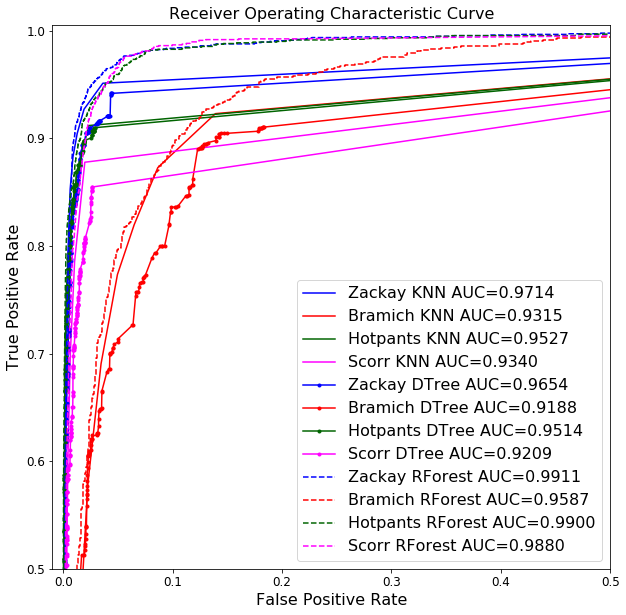

In [152]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sps = ['Scorr']

sub_methods = [zky, bch, hot, sps]

colors = ['blue', 'red', 'darkgreen', 'magenta']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest, rslts_sps_rforest],
              'DTree': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini, rslts_sps_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45, rslts_sps_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc, rslts_sps_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform, rslts_knn_sps_uniform]}#,
              #'SVMRBF'    : [rslts_zps_rbfsvc, rslts_ois_rbfsvc, rslts_hot_rbfsvc]}

del ml_methods['SVM']
del ml_methods['C45']

ls = ['-', '.-', '--', '-.', ':', '.']
j = 0
plt.figure(figsize=(10, 10))
for k, v in ml_methods.iteritems():
    for i in range(4):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        roc_auc = sub_method['roc_auc']
        sub_meth_col.append(roc_auc)
        
        label = sub_meth_col[0]+' '+k+' AUC={:06.4f}'.format(roc_auc)
        plt.plot(fpr, tpr, ls[j], lw=1.5, color=colors[i], label=label)
    j+=1

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right', fontsize=16)
plt.title('Receiver Operating Characteristic Curve', fontsize=16)

plt.xlim([-0.01, 0.50])
plt.ylim([0.5, 1.005])
plt.savefig('roc_without_pca.png')

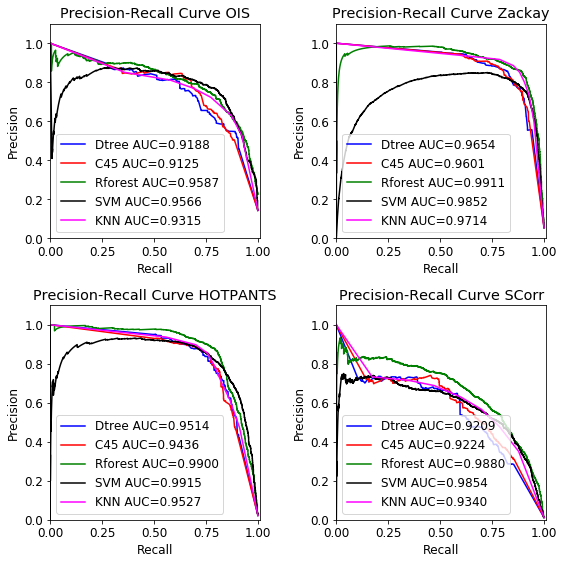

In [153]:
plt.figure(figsize=(8, 8))
#plt.figaspect(.8)
plt.subplot(221)
res_Dtree = rslts_ois_dtree_gini
res_C45 = rslts_ois_c45
res_Rforest = rslts_ois_rforest
res_svc = rslts_ois_svc
res_knn = rslts_knn_ois_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve OIS')

plt.subplot(222)
res_Dtree = rslts_zps_dtree_gini
res_C45 = rslts_zps_c45
res_Rforest = rslts_zps_rforest
res_svc = rslts_zps_svc
res_knn = rslts_knn_zps_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve Zackay')


plt.subplot(223)
res_Dtree = rslts_hot_dtree_gini
res_C45 = rslts_hot_c45
res_Rforest = rslts_hot_rforest
res_svc = rslts_hot_svc
res_knn = rslts_knn_hot_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve HOTPANTS')

plt.subplot(224)
res_Dtree = rslts_sps_dtree_gini
res_C45 = rslts_sps_c45
res_Rforest = rslts_sps_rforest
res_svc = rslts_sps_svc
res_knn = rslts_knn_sps_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve SCorr')

plt.tight_layout()

plt.savefig('prec_rec_without_pca.png')

In [168]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          printcm=False, 
                          colorbar=False, 
                          thresh=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if colorbar:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if printcm:
            print(cm)
            print("Normalized confusion matrix")
    else:
        if printcm:
            print(cm)
            print('Confusion matrix, without normalization')

    if thresh is None:
        thresh = 0.74 #cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

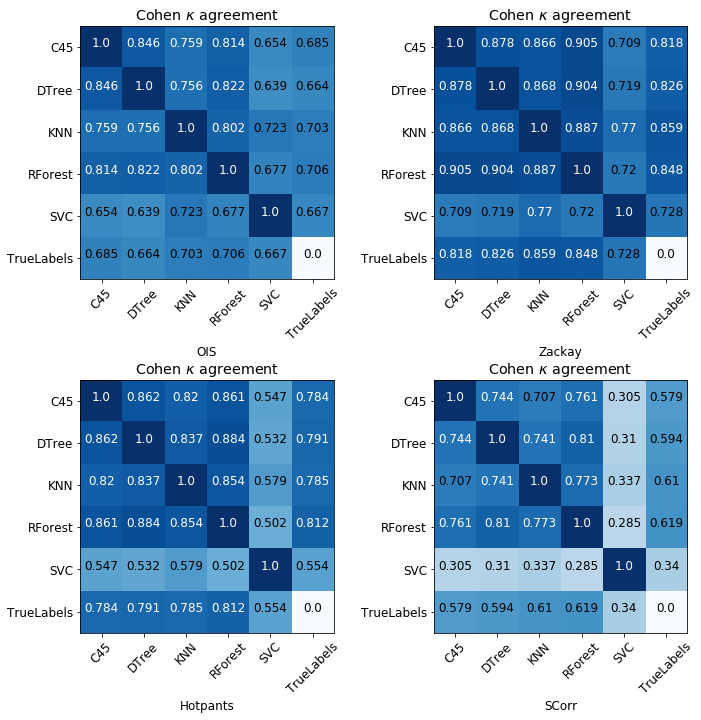

In [155]:
m_coll = []

res_Dtree = rslts_ois_dtree_gini
res_C45 = rslts_ois_c45
res_Rforest = rslts_ois_rforest
res_svc = rslts_ois_svc
res_knn = rslts_knn_ois_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])

res_Dtree = rslts_zps_dtree_gini
res_C45 = rslts_zps_c45
res_Rforest = rslts_zps_rforest
res_svc = rslts_zps_svc
res_knn = rslts_knn_zps_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])
 
res_Dtree = rslts_hot_dtree_gini
res_C45 = rslts_hot_c45
res_Rforest = rslts_hot_rforest
res_svc = rslts_hot_svc
res_knn = rslts_knn_hot_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])

res_Dtree = rslts_sps_dtree_gini
res_C45 = rslts_sps_c45
res_Rforest = rslts_sps_rforest
res_svc = rslts_sps_svc
res_knn = rslts_knn_sps_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])
names = ['OIS', 'Zackay', 'Hotpants', 'SCorr']

plt.figure(figsize=(10, 10))
for k, methods in enumerate(m_coll):
    kappa_agreement = np.ones((len(methods), len(methods)))

    for i in range(len(methods)):
        for j in range(i+1):
            kappa_agreement[i, j] = metrics.cohen_kappa_score(methods[i]['predictions'],
                                                              methods[j]['predictions'])#, 
                                                              #labels=['star', 'galaxy'])
            kappa_agreement[j, i] = kappa_agreement[i, j]
    kappa_agreement[-1, -1] = 0
    plt.subplot(2, 2, k+1)
    
    plot_confusion_matrix(np.round(kappa_agreement, 3), 
                          classes=['C45', 'DTree', 'KNN', 'RForest', 'SVC', 'TrueLabels'],
                          title=r'Cohen $\kappa$ agreement')
    #plt.tight_layout()
    plt.xlabel(names[k])
    plt.ylabel('')


plt.savefig('cohen_without_pca.png')

In [156]:
aucs = pd.DataFrame([zky, bch, hot, sps], columns=['SubMethod','DTreeGini', 'RForest', 'KNN'], )

In [157]:
AUCTable = aucs.set_index(['SubMethod'])

In [158]:
AUCTable

,DTreeGini,RForest,KNN
SubMethod,,,
Zackay,0.971443,0.965428,0.991075
Bramich,0.931514,0.918810,0.958719
Hotpants,0.952697,0.951444,0.990024
Scorr,0.933982,0.920913,0.988015


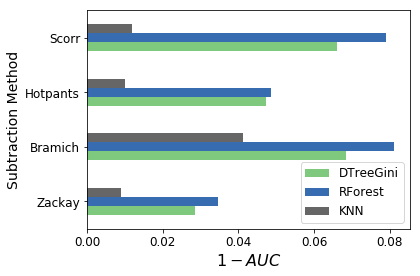

In [159]:
(1-AUCTable).plot.barh(log=False, cmap='Accent')
plt.xlabel(r'$1-AUC$', fontsize=16)
plt.ylabel('Subtraction Method', fontsize=14)
plt.tight_layout()
#plt.xlim(0, 0.3)
plt.legend(loc='best', fontsize=12)
plt.savefig('./plots/complementary_AUC2.png', dpi=600)

## Cost curves

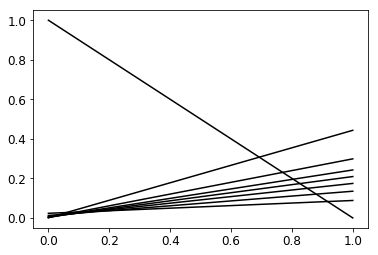

In [160]:
fpr = rslts_knn_hot_uniform['fpr']
tpr = rslts_knn_hot_uniform['tpr']
thr = rslts_knn_hot_uniform['thresh']
plt.figure()
prev_thr = 1.
for fp, tp, th in zip(fpr, tpr, thr):
    if (prev_thr-th) >= 0.:
        x_ax = np.linspace(0,1,10)
        y_ax = (1-tp-fp)*x_ax + fp

        plt.plot(x_ax, y_ax, 'k-', alpha=1)
        prev_thr = th

In [161]:
print tpr[-10:]

[ 0.          0.55681818  0.70120321  0.75735294  0.7907754   0.82553476
  0.86497326  0.91176471  1.        ]


In [162]:
def cost_curve(fpr, tpr):
    prev_fp = 0.
    prev_tp = 0.

    p_plus = [0.]
    er = [0.]
    for fp, tp in zip(fpr, tpr):
        delta_fp = fp - prev_fp
        if delta_fp != 0.:
            slp = (tp - prev_tp)/(delta_fp)
            tp_0= prev_tp - slp*prev_fp
            p_plus.append(1./(1.+slp))
            er.append(p_plus[-1]*(1-tp_0))

    p_plus.append(1.)
    er.append(0.)
    return(p_plus, er)

(0, 1)

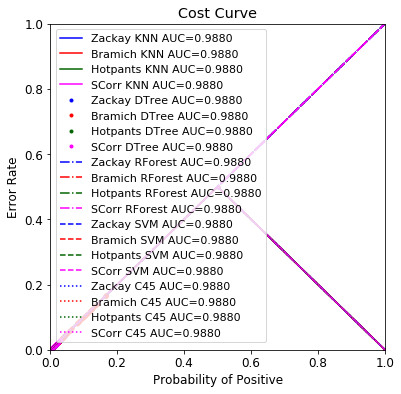

In [163]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sps = ['SCorr']
sub_methods = [zky, bch, hot, sps]

colors = ['blue', 'red', 'darkgreen', 'magenta']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest, rslts_sps_rforest],
              'DTree': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini, rslts_sps_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45, rslts_sps_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc, rslts_sps_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform, rslts_knn_sps_uniform]}#,
              #'SVMRBF'    : [rslts_zps_rbfsvc, rslts_ois_rbfsvc, rslts_hot_rbfsvc]}

ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(6, 6))
for k, v in ml_methods.iteritems():
    for i in range(4):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        p_plus, er = cost_curve(fpr, tpr)
        
        sub_meth_col.append(roc_auc)
        
        label = sub_meth_col[0]+' '+k+' AUC={:06.4f}'.format(roc_auc)
        plt.plot(p_plus, er, ls[j], lw=1.5, color=colors[i], label=label)
    j+=1

plt.xlabel('Probability of Positive')
plt.ylabel('Error Rate')
plt.legend(loc='upper left', fontsize=11)
plt.title('Cost Curve')

plt.xlim(0, 1)
plt.ylim(0, 1)


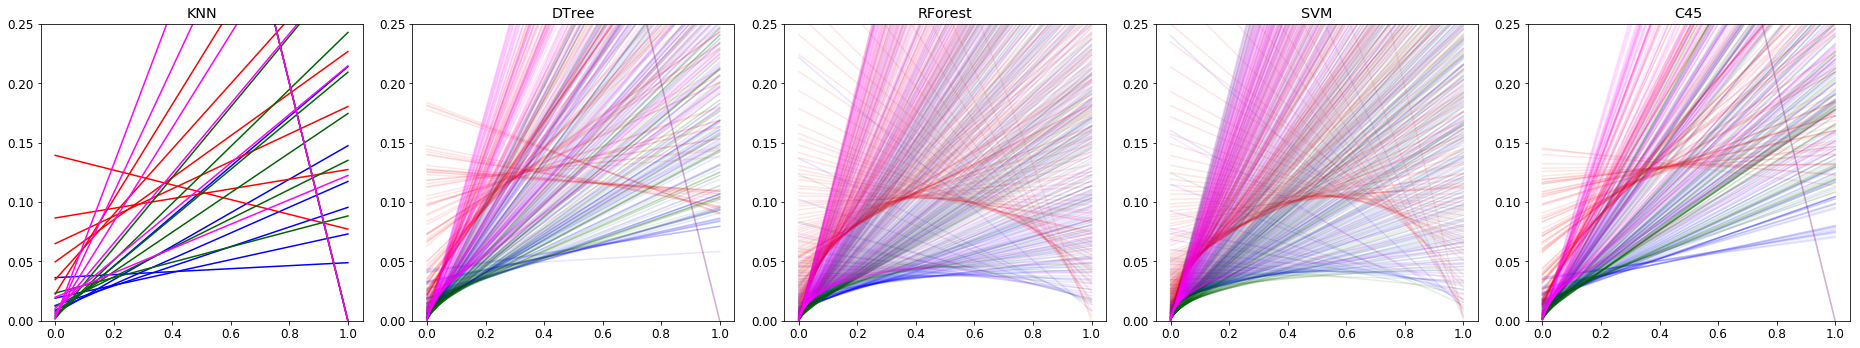

In [164]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sps = ['SCorr']
sub_methods = [zky, bch, hot, sps]

colors = ['blue', 'red', 'darkgreen', 'magenta']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest, rslts_sps_rforest],
              'DTree': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini, rslts_sps_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45, rslts_sps_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc, rslts_sps_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform, rslts_knn_sps_uniform]}#,
              #'SVMRBF'    : [rslts_zps_rbfsvc, rslts_ois_rbfsvc, rslts_hot_rbfsvc]}

ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(26, 5))
for k, v in ml_methods.iteritems():
    plt.subplot(1, 5, j+1)
    plt.title(k)
    for i in range(4):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        thr = sub_method['thresh']
        prev_thr = 1.
        if k=='KNN':
            alpha = 1
        else: alpha=0.1
        for fp, tp, th in zip(fpr, tpr, thr):
            if (prev_thr-th) >= 0.005:
                x_ax = np.linspace(0,1,10)
                y_ax = (1-tp-fp)*x_ax + fp

                plt.plot(x_ax, y_ax, '-', color=colors[i], alpha=alpha)
                prev_thr = th
    plt.ylim(0, 0.25)
    j+=1
plt.tight_layout()

plt.savefig('cost_without_pca.png')

## Confusion Matrix

In [165]:
mt_names = ['zackay', 'bramich', 'alard', 'scorr']

In [166]:
ml_methods.keys()

['KNN', 'DTree', 'RForest', 'SVM', 'C45']

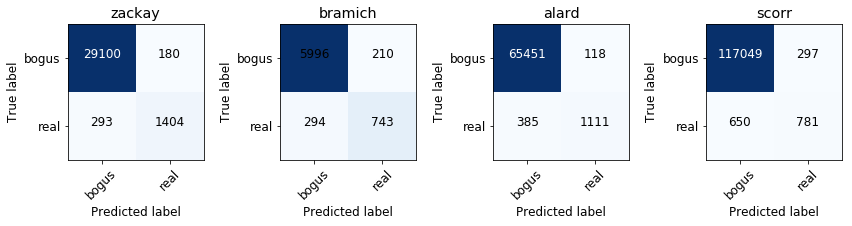

In [169]:
plt.figure(figsize=(12,6))
ii = 0 
for amth in ml_methods['RForest']:
    plt.subplot(1, 4, ii+1)
    plot_confusion_matrix(amth['confusion_matrix'],['bogus', 'real'], normalize=False, thresh=20000, title=mt_names[ii])
    ii += 1
plt.savefig('./plots/confusion_matrix_RForest.png', dpi=600)

## With PCA

### K-Nearest Neighbors


**OIS**

In [ ]:
rslts_knn_ois_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_ois_t, Y_ois.as_matrix())

**Zackay**

In [ ]:
rslts_knn_zps_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [ ]:
rslts_knn_hot_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_hot_t, Y_hot.as_matrix())

### Support vector machines

**OIS**

In [ ]:
rslts_ois_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_ois_t, Y_ois.as_matrix())

**Zackay**

In [ ]:
rslts_zps_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [ ]:
rslts_hot_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_hot_t, Y_hot.as_matrix())

### Decision tree (gini)

**OIS**

In [ ]:
rslts_ois_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_ois_t, Y_ois.as_matrix())

**Zackay**

In [ ]:
rslts_zps_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [ ]:
rslts_hot_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_hot_t, Y_hot.as_matrix())

### Random forest

**OIS**

In [ ]:
rslts_ois_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_ois_t, Y_ois.as_matrix())

**Zackay**

In [ ]:
rslts_zps_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [ ]:
rslts_hot_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_hot_t, Y_hot.as_matrix())

### DecisionTreeClassifier (C45)

**OIS**

In [ ]:
rslts_ois_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_ois_t, Y_ois.as_matrix())

**Zackay**

In [ ]:
rslts_zps_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [ ]:
rslts_hot_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_hot_t, Y_hot.as_matrix())

In [ ]:
gc.collect()

### ROC curve

In [ ]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sub_methods = [zky, bch, hot]

colors = ['blue', 'red', 'darkgreen']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest],
              'DTree Gini': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform]}


ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(10, 10))
for k, v in ml_methods.iteritems():
    for i in range(3):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        roc_auc = sub_method['roc_auc']
        sub_meth_col.append(roc_auc)
        
        label = sub_meth_col[0]+' '+k+' AUC={:06.4f}'.format(roc_auc)
        plt.plot(fpr, tpr, ls[j], lw=1.5, color=colors[i], label=label)
    j+=1

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=11)
plt.title('Receiver Operating Characteristic Curve')

plt.xlim([-0.01, 0.50])
plt.ylim([0.5, 1.005])
plt.savefig('roc_with_pca.png')

In [ ]:
plt.figure(figsize=(16, 5))
#plt.figaspect(.8)
plt.subplot(131)
res_Dtree = rslts_ois_dtree_gini
res_C45 = rslts_ois_c45
res_Rforest = rslts_ois_rforest
res_svc = rslts_ois_svc
res_knn = rslts_knn_ois_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve OIS')

plt.subplot(132)
res_Dtree = rslts_zps_dtree_gini
res_C45 = rslts_zps_c45
res_Rforest = rslts_zps_rforest
res_svc = rslts_zps_svc
res_knn = rslts_knn_zps_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))
0
pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve Zackay')


plt.subplot(133)
res_Dtree = rslts_hot_dtree_gini
res_C45 = rslts_hot_c45
res_Rforest = rslts_hot_rforest
res_svc = rslts_hot_svc
res_knn = rslts_knn_hot_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve HOTPANTS')

plt.tight_layout()

plt.savefig('prec_rec_with_pca.png')

In [ ]:
m_coll = []

res_Dtree = rslts_ois_dtree_gini
res_C45 = rslts_ois_c45
res_Rforest = rslts_ois_rforest
res_svc = rslts_ois_svc
res_knn = rslts_knn_ois_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])

res_Dtree = rslts_zps_dtree_gini
res_C45 = rslts_zps_c45
res_Rforest = rslts_zps_rforest
res_svc = rslts_zps_svc
res_knn = rslts_knn_zps_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])
 
res_Dtree = rslts_hot_dtree_gini
res_C45 = rslts_hot_c45
res_Rforest = rslts_hot_rforest
res_svc = rslts_hot_svc
res_knn = rslts_knn_hot_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])
names = ['OIS', 'Zackay', 'Hotpants']

plt.figure(figsize=(16, 6))
for k, methods in enumerate(m_coll):
    kappa_agreement = np.ones((len(methods), len(methods)))

    for i in range(len(methods)):
        for j in range(i+1):
            kappa_agreement[i, j] = metrics.cohen_kappa_score(methods[i]['predictions'],
                                                              methods[j]['predictions'])#, 
                                                              #labels=['star', 'galaxy'])
            kappa_agreement[j, i] = kappa_agreement[i, j]
    kappa_agreement[-1, -1] = 0
    plt.subplot(1, 3, k+1)
    
    plot_confusion_matrix(np.round(kappa_agreement, 3), 
                          classes=['C45', 'DTree', 'KNN', 'RForest', 'SVC', 'TrueLabels'],
                          title=r'Cohen $\kappa$ agreement')
    #plt.tight_layout()
    plt.xlabel(names[k])
    plt.ylabel('')


plt.savefig('cohen_with_pca.png')

In [ ]:
aucs = pd.DataFrame([zky, bch, hot], columns=['SubMethod','DTreeGini', 'C45', 'RandomForest', 'KNN', 'SVM'], )

In [ ]:
AUCTable = aucs.set_index(['SubMethod'])

In [ ]:
AUCTable

In [ ]:
(1-AUCTable).plot.barh(log=False, cmap='Accent')
plt.xlabel(r'$1-AUC$', fontsize=16)
plt.ylabel('Subtraction Method', fontsize=14)
plt.tight_layout()
plt.xlim(0, 0.3)
plt.legend(loc='best', fontsize=12)
plt.savefig('./plots/complementary_AUC2_withPCA.png', dpi=600)

## Cost curves

In [ ]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sub_methods = [zky, bch, hot]

colors = ['blue', 'red', 'darkgreen']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest],
              'DTree Gini': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform]}


ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(26, 5))
for k, v in ml_methods.iteritems():
    plt.subplot(1, 5, j+1)
    plt.title(k)
    for i in range(3):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        thr = sub_method['thresh']
        prev_thr = 1.
        if k=='KNN':
            alpha = 1
        else: alpha=0.1
        for fp, tp, th in zip(fpr, tpr, thr):
            if (prev_thr-th) >= 0.005:
                x_ax = np.linspace(0,1,10)
                y_ax = (1-tp-fp)*x_ax + fp

                plt.plot(x_ax, y_ax, '-', color=colors[i], alpha=alpha)
                prev_thr = th
    plt.ylim(0, 0.25)
    j+=1
plt.tight_layout()

plt.savefig('cost_with_pca.png')

In [ ]:
gc.collect()